# Momentum Effect with Volume

Takes a long or short position in the stock, in hopes that momentum will continue in the same direction. Has higher degree of volatility than most strategies

Portfolio constructed with highest turnover from the top momentum decile and highest turnover from the bottom momentum decile

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)
from decimal import ROUND_HALF_UP, Decimal
from statsmodels.api import OLS
import random
import statsmodels.api as sm
from ta.volume import volume_weighted_average_price
from ta.momentum import roc
from tqdm.auto import tqdm
tqdm.pandas()


In [2]:
train_stock_prices = pd.read_csv('ds/train_files/stock_prices.csv')
supplemental_stock_prices = pd.read_csv('ds/supplemental_files/stock_prices.csv')
data_stock_prices = pd.concat([train_stock_prices,supplemental_stock_prices],ignore_index=True)

In [3]:
train_financials = pd.read_csv('ds/train_files/financials.csv',low_memory=False)
train_financials["Date"] = pd.to_datetime(train_financials["Date"])
train_financials["AverageNumberOfShares"] = pd.to_numeric(train_financials["AverageNumberOfShares"],errors='coerce')

In [4]:
train_financials[(~train_financials["AverageNumberOfShares"].isna()) & (train_financials["SecuritiesCode"]==7453)]

,DisclosureNumber,DateCode,Date,SecuritiesCode,DisclosedDate,DisclosedTime,DisclosedUnixTime,TypeOfDocument,CurrentPeriodEndDate,TypeOfCurrentPeriod,...,ForecastEarningsPerShare,ApplyingOfSpecificAccountingOfTheQuarterlyFinancialStatements,MaterialChangesInSubsidiaries,ChangesBasedOnRevisionsOfAccountingStandard,ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard,ChangesInAccountingEstimates,RetrospectiveRestatement,NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock,NumberOfTreasuryStockAtTheEndOfFiscalYear,AverageNumberOfShares
9,2.017010e+13,20170105_7453,2017-01-05,7453.0,2017-01-05,15:00:00,1.483596e+09,3QFinancialStatements_Consolidated_JP,2016-11-30,3Q,...,913.28,NaN,False,True,True,False,False,28078000,1702372,26527712.0
4851,2.017041e+13,20170412_7453,2017-04-12,7453.0,2017-04-12,15:00:00,1.491977e+09,FYFinancialStatements_Consolidated_JP,2017-02-28,FY,...,1078.65,NaN,False,True,False,False,False,28078000,1656122,26494010.0
9496,2.017070e+13,20170705_7453,2017-07-05,7453.0,2017-07-05,15:00:00,1.499234e+09,1QFinancialStatements_Consolidated_JP,2017-05-31,1Q,...,1078.65,NaN,False,False,False,False,False,28078000,1859066,26337719.0
13774,2.017100e+13,20171004_7453,2017-10-04,7453.0,2017-10-04,15:00:00,1.507097e+09,2QFinancialStatements_Consolidated_JP,2017-08-31,2Q,...,1098.19,NaN,False,False,False,False,False,28078000,1852966,26279828.0
18681,2.018011e+13,20180110_7453,2018-01-10,7453.0,2018-01-10,15:00:00,1.515564e+09,3QFinancialStatements_Consolidated_JP,2017-11-30,3Q,...,1098.19,NaN,False,False,False,False,False,28078000,1849666,26262009.0
23372,2.018041e+13,20180411_7453,2018-04-11,7453.0,2018-04-11,15:00:00,1.523426e+09,FYFinancialStatements_Consolidated_JP,2018-02-28,FY,...,1269.1,NaN,False,False,False,False,False,28078000,1838866,26254807.0
27896,2.018070e+13,20180704_7453,2018-07-04,7453.0,2018-07-04,15:00:00,1.530684e+09,1QFinancialStatements_Consolidated_JP,2018-05-31,1Q,...,1269.1,NaN,False,False,False,False,False,28078000,1835076,26241125.0
32113,2.018100e+13,20181003_7453,2018-10-03,7453.0,2018-10-03,15:00:00,1.538546e+09,2QFinancialStatements_Consolidated_JP,2018-08-31,2Q,...,1269.1,NaN,False,False,False,False,False,28078000,1821176,26245755.0
36790,2.019011e+13,20190109_7453,2019-01-09,7453.0,2019-01-09,15:00:00,1.547014e+09,3QFinancialStatements_Consolidated_JP,2018-11-30,3Q,...,1409.53,NaN,False,False,False,False,False,28078000,1816776,26249816.0
41461,2.019041e+13,20190410_7453,2019-04-10,7453.0,2019-04-10,15:00:00,1.554876e+09,FYFinancialStatements_Consolidated_JP,2019-02-28,FY,...,1210.54,NaN,False,False,False,False,False,28078000,1808786,26253669.0


In [5]:
def calc_adjusted_close(df):
    df = df.sort_values("Date",ascending=False)
    df.loc[:,"cummulative_adjustment_factor"] = df["AdjustmentFactor"].cumprod()
    df.loc[:,"adjusted_close"] = (df["cummulative_adjustment_factor"]*df["Close"]).map(lambda x: float(Decimal(str(x)).quantize(Decimal("0.1"),rounding=ROUND_HALF_UP)))
    df.loc[:,"adjusted_open"] = (df["cummulative_adjustment_factor"]*df["Open"]).map(lambda x: float(Decimal(str(x)).quantize(Decimal("0.1"),rounding=ROUND_HALF_UP)))
    df.loc[:,"adjusted_high"] = (df["cummulative_adjustment_factor"]*df["High"]).map(lambda x: float(Decimal(str(x)).quantize(Decimal("0.1"),rounding=ROUND_HALF_UP)))
    df.loc[:,"adjusted_low"] = (df["cummulative_adjustment_factor"]*df["Low"]).map(lambda x: float(Decimal(str(x)).quantize(Decimal("0.1"),rounding=ROUND_HALF_UP)))
    df = df.sort_values("Date")
    df.loc[df["adjusted_close"]==0,"adjusted_close"] = np.nan
    df.loc[:,"adjusted_close"] = df.loc[:,"adjusted_close"].ffill()
    return df

In [6]:
def calc_adjusted_volume(df):
    df.loc[:,"adjusted_volume"] = (df["Volume"]/df["cummulative_adjustment_factor"]).map(lambda x: float(Decimal(str(x)).quantize(Decimal("0.1"),rounding=ROUND_HALF_UP)))
    df = df.sort_values("Date")
    df.loc[df["adjusted_volume"]==0,"adjusted_volume"] = np.nan
    df.loc[:,"adjusted_volume"] = df.loc[:,"adjusted_volume"].ffill()
    return df

In [7]:

def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        #Target is the rate of change 
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    print(buf.mean())
    print(buf.std())
    buf.plot()
    return sharpe_ratio

In [8]:
def create_momentum_deciles(df):
    
    headIndex = df.index[:200]
    tailIndex = df.index[-200:]
    df.loc[headIndex,"Quarter"] =  0
    df.loc[tailIndex,"Quarter"] = 2
    df["Quarter"] = df["Quarter"].fillna(1)
    return df

In [9]:
def sort_deciles(df):
    #Sort by rocv or turnover
    t1 = df.loc[df["Quarter"]==0,:].sort_values(["ROCV"],ascending=False)
    t2 =  df.loc[df["Quarter"]==1,:]
    t3 = df.loc[df["Quarter"]==2,:].sort_values(["ROCV"],ascending=True)
    return pd.concat([t1,t2,t3],ignore_index=True)


In [38]:
def create_features(df,n,m):
    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.drop(["RowId"],axis=1)
    df = df[df["Date"]!="2020-10-01"]
    df = df.groupby("SecuritiesCode").apply(calc_adjusted_close).reset_index(drop=True).sort_values(["Date","SecuritiesCode"]).reset_index(drop=True)
    df = df.groupby("SecuritiesCode").apply(calc_adjusted_volume).reset_index(drop=True).sort_values(["Date","SecuritiesCode"]).reset_index(drop=True)
    df["ROC"] = df.groupby("SecuritiesCode")["adjusted_close"].pct_change(n)
    df["ROCV"] =df.groupby("SecuritiesCode")["adjusted_volume"].pct_change(m)
    df = df.join(train_financials[["Date","SecuritiesCode","AverageNumberOfShares"]].set_index(["Date","SecuritiesCode"]), on=["Date","SecuritiesCode"]).reset_index(drop=True)
    df["AverageNumberOfShares"] = df.groupby(["SecuritiesCode"])["AverageNumberOfShares"].ffill()
    df["AverageNumberOfShares"] = (df["AverageNumberOfShares"]/df["cummulative_adjustment_factor"]).map(lambda x: float(Decimal(str(x)).quantize(Decimal("0.1"),rounding=ROUND_HALF_UP)))
    df["AverageAnnualVolume"] =df.groupby(["SecuritiesCode"])["adjusted_volume"].rolling(243).mean().reset_index(0,drop=True)
    df["Turnover"] = df["adjusted_volume"]/df["AverageNumberOfShares"]
    df = df.dropna(subset=["ROC","Turnover"])
    df = df.sort_values(["Date","ROC"],ascending=[True,False])
    df = df.groupby(["Date"]).apply(lambda x: create_momentum_deciles(x))
    df = df.groupby(["Date"]).apply(lambda x: sort_deciles(x))
    df = df.reset_index(drop=True)
    df["Rank"] =  df.groupby("Date")["SecuritiesCode"].transform(lambda x:np.linspace(0,x.count()-1,x.count()))
    return df

In [39]:
test = create_features(train_stock_prices,5,5)

0.0011108829221844422
2.120124472839443


0.0005239706141859953

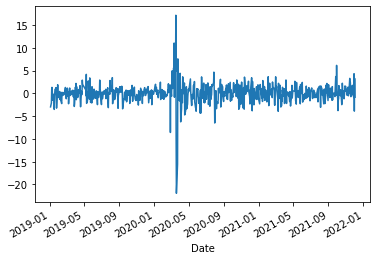

In [34]:
test = test[test["Date"]>="2019"]
calc_spread_return_sharpe(test)

0.007471908746588446
2.139063229058431


0.003493075213993285

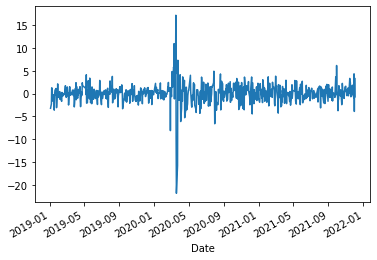

In [40]:
test = test[test["Date"]>="2019"]
calc_spread_return_sharpe(test)